# Прогнозирование удовлетворённости сотрудников и риска их увольнения

**Цель исследования:** Построить 2 модели м.о. для прогнозирования ключевых показателей в области управления персоналом: уровня удовлетворённости работой сотрудника и вероятности его увольнения из компании. В рамках первой задачи предсказывается числовой показатель job_satisfaction_rate (от 0 до 1) с использованием метрики SMAPE. Во второй задаче строится классификатор для определения вероятности ухода сотрудника, используя метрику ROC-AUC. Обе модели разрабатываются на основе одних и тех же входных данных, а также предусматривается интеграция предсказанного уровня удовлетворённости как нового признака во вторую модель. Результаты исследования должны помочь HR-отделу компании «Работа с заботой» более эффективно выявлять группы риска по оттоку сотрудников и принимать обоснованные управленческие решения для повышения лояльности персонала и снижения финансовых потерь.

## Задача 1: предсказание уровня удовлетворённости сотрудника

### 1 Загрузка данных

#### 1.1 Установка библиотек

In [1]:
#!pip install phik -q
#!pip install shap -q

#### 1.2 Импорт библиотек

In [2]:
# для работы с датафреймами
import pandas as pd

# для работы с числами
import numpy as np

# для работы с графиками
import matplotlib.pyplot as plt 
import seaborn as sns

# для работы с пайплайнами
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# для работы с пропусками
from sklearn.impute import SimpleImputer

# для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)

# для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# модели регрессии
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# модели классификации
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# метрики
from sklearn.metrics import roc_auc_score, make_scorer

# для корреляционного анализа
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# для отбора признаков
import shap

#### 1.3 Загрузка таблиц

`train_job_satisfaction_rate` - Тренировочная выборка для первой задачи

In [3]:
try:
    train_job_satisfaction_rate = pd.read_csv('datasets/train_job_satisfaction_rate.csv', index_col='id')
except:
    train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', index_col='id')

`test_features` - Входные данные тестовой выборки, которые будут использоваться для обоих задач

In [4]:
try:
    test_features = pd.read_csv('datasets/test_features.csv', index_col='id')
except:
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', index_col='id')

`test_target_job_satisfaction_rate` - Целевой признак тестовой выборки для первой задачи

In [5]:
try:
    test_target_job_satisfaction_rate = pd.read_csv('datasets/test_target_job_satisfaction_rate.csv', index_col='id')
except:
    test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv', index_col='id')

#### 1.4 Общая информация

Изучим общую иформацию о таблицах: выведем информацию о колонках и первые 10 строк

In [6]:
# функция для изучения общей информации о таблицах
def df_info(df):
    df.info()
    return df.head(10)

In [7]:
df_info(train_job_satisfaction_rate)

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20
405448,hr,middle,low,7,no,no,4,30000,0.78
857135,sales,sinior,medium,9,no,no,3,56400,0.56
400657,purchasing,middle,high,9,no,no,3,52800,0.44
198846,hr,junior,low,1,no,no,2,13200,0.14


In [8]:
df_info(test_features)

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800
429973,purchasing,middle,medium,6,no,no,3,42000
850699,technology,junior,medium,3,no,no,3,26400
500791,sales,middle,high,9,no,no,4,49200
767867,marketing,middle,high,3,no,yes,4,62400


In [9]:
df_info(test_target_job_satisfaction_rate)

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08
817219,0.76
269033,0.64
962356,0.38
649052,0.14


Изучив общую информацию о датафреймах, можно заметить следующее: 
 - В датафреймах встречаются пропуски в столбцах *dept* и *level*
 - Тренировочная выборка в 2 раза больше тестовой
 - Идентификаторы входных признаков тестовой выборки и таргета тестовой выборки располагаются в разном порядке
 - Названия столбцов приведены к snake_case
 - Идентификаторы работников располагаются в случайном порядке
 - Типы данных определились верно
 - Слово senior в столбце *level* написано с ошибкой
 - В столбцах с типом object могут быть неявные дубликаты
 - Также дубликаты возможны в столбце идентификаторов работников

Все это нужно проверить и обработать на следующих этапах.

**Промежуточный вывод:** В результате загрузки данных, были установлены и импортированы необходимые библиотеки, загружены данные и получено общее представление об изучаемых данных, что упростит дальнейшую работу с ними.

### 2 Предобработка данных

#### 2.1 Объединение тестовой выборки

Объединим входные признаки и таргет тестовой выборки, чтобы совместить соответсвующие индексы

In [10]:
# объединяем таблицы
test_job_satisfaction_rate = test_features.join(test_target_job_satisfaction_rate, how='left')

In [11]:
# проверяем
test_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1998 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 220.8+ KB


Значений столько, сколько нужно, объединение прошло корректно

#### 2.2 Обработка пропусков

Во время изучения общей информации были замечены пропуски в *dept* и *level*. Поскольку все значения слишком близко, предугадать к какому именно отделу относится каждый работник не получится, поэтому напишем пайплайн, который заменит пропуски на самые частые значения. Но также пропуски могут быть неявными, проверим уникальные значения, чтобы вычислить их

In [12]:
# функция для вывода уникальных значений
def object_unique(df):
    for i in df.columns:
        if df[i].dtype == 'object':
            print(f'{i:<20}: {df[i].unique()}')

In [13]:
object_unique(train_job_satisfaction_rate)

dept                : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level               : ['junior' 'middle' 'sinior' nan]
workload            : ['medium' 'high' 'low']
last_year_promo     : ['no' 'yes']
last_year_violations: ['no' 'yes']


In [14]:
object_unique(test_job_satisfaction_rate)

dept                : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level               : ['junior' 'middle' 'sinior' nan]
workload            : ['medium' 'low' 'high' ' ']
last_year_promo     : ['no' 'yes']
last_year_violations: ['no' 'yes']


Действительно, в столбцах *dept* и *workload* есть пустые значения, которые тоже надо заменить, но сначала посмотрим на их количество

In [15]:
print(f'''Количество неявных пропусков
в dept: {test_job_satisfaction_rate.query('dept==" "')['dept'].count()}
в workload: {test_job_satisfaction_rate.query('workload==" "')['workload'].count()}''')

Количество неявных пропусков
в dept: 1
в workload: 1


Всего по 1 пропуску, их тоже надо заменить

In [16]:
imput_pipe = Pipeline([
    ('imput_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('imput_empty', SimpleImputer(missing_values=' ', strategy='most_frequent'))
])

Поскольку пропусков слишком мало, они не повлияют на исследовательский анализ данных, поэтому пайплайн применим во время подготовки данных к обучению

#### 2.3 Обработка дубликатов

Сначала обработаем неявные дубликаты в столбцах с типом *object*, посмотрев на уникальные значения ранее написанной функцией

In [17]:
object_unique(train_job_satisfaction_rate)

dept                : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level               : ['junior' 'middle' 'sinior' nan]
workload            : ['medium' 'high' 'low']
last_year_promo     : ['no' 'yes']
last_year_violations: ['no' 'yes']


Дубликатов нет, но слово *senior* написано с ошибкой, исправим

In [18]:
# исправляем опечатку
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].replace('sinior', 'senior')

In [19]:
# проверяем
train_job_satisfaction_rate['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [20]:
object_unique(test_job_satisfaction_rate)

dept                : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level               : ['junior' 'middle' 'sinior' nan]
workload            : ['medium' 'low' 'high' ' ']
last_year_promo     : ['no' 'yes']
last_year_violations: ['no' 'yes']


Здесь снова та же опечатка

In [21]:
test_job_satisfaction_rate['level'] = test_job_satisfaction_rate['level'].replace('sinior', 'senior')

In [22]:
test_job_satisfaction_rate['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

Теперь проверим таблицы на дублирующиеся строки по значениям индексов

In [23]:
len(train_job_satisfaction_rate.index.unique())

4000

In [24]:
len(test_job_satisfaction_rate.index.unique())

2000

Количество уникальных значений соответствует количеству строк в таблицах, следовательно дубликатов нет

**Промежуточный вывод:** В результате предобработки данных, были объединены входные признаки и таргет тестовой выборки, обработаны пропуски в таблицах и дубликаты, что облегчит дальнейшую работу с данными

### 3 Исследовательский анализ данных

Напишем функцию для построения графиков и анализа, которую уже будем применять к таблицам

In [25]:
# функция для построения графиков для непрерывных числовых признаков
def continuous_num_plots(col, bins=30):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    fig.suptitle(f'Распределение признака {col.name}')
    
    # гистограмма
    sns.histplot(col, bins=bins, ax=axes[0])
    axes[0].set_xlabel(col.name)
    axes[0].set_ylabel('Количество значений')
    
    # ящик с усами
    sns.boxplot(col, orient='h', ax=axes[1])
    axes[1].set_xlabel(col.name)
    
    plt.show()
    print(col.describe())

In [26]:
# функция для построения графиков для дискретных числовых признаков
def discrete_num_plots(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    fig.suptitle(f'Распределение признака {col.name}')

    # гистограмма
    sns.barplot(col.value_counts(), ax=axes[0])
    axes[0].set_xlabel(col.name)
    axes[0].set_ylabel('Количество значений')

    # ящик с усами
    sns.boxplot(col, orient='h', ax=axes[1])
    axes[1].set_xlabel(col.name)

    plt.show()
    print(col.describe())

In [27]:
def category_plots(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    fig.suptitle(f'Распределение признака {col.name}')
    
    # круговая диаграмма
    col.value_counts().plot(kind='pie', autopct='%1.0f%%', ax=axes[0])
    axes[0].set_ylabel('')

    # столбчатая диаграмма
    sns.barplot(col.value_counts(), orient='h', ax=axes[1])
    axes[1].set_xlabel('Количество значений')
    axes[1].set_ylabel('')
    
    plt.show()
    print(col.value_counts())

In [28]:
def table_plots(df, continuous_cols, discrete_cols, category_cols):
    if continuous_cols:
        for col in continuous_cols:
            continuous_num_plots(df[col])
    if discrete_cols:
        for col in discrete_cols:
            discrete_num_plots(df[col])
    if category_cols:
        for col in category_cols:
            category_plots(df[col])

In [29]:
# устанавливаем цветовую схему
sns.set_palette('pastel')

#### 3.1 Таблица train_job_satisfaction_rate

In [30]:
# определяем столбцы по категориям
continuous_cols = ['salary', 'job_satisfaction_rate']
discrete_cols = ['employment_years', 'supervisor_evaluation']
category_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

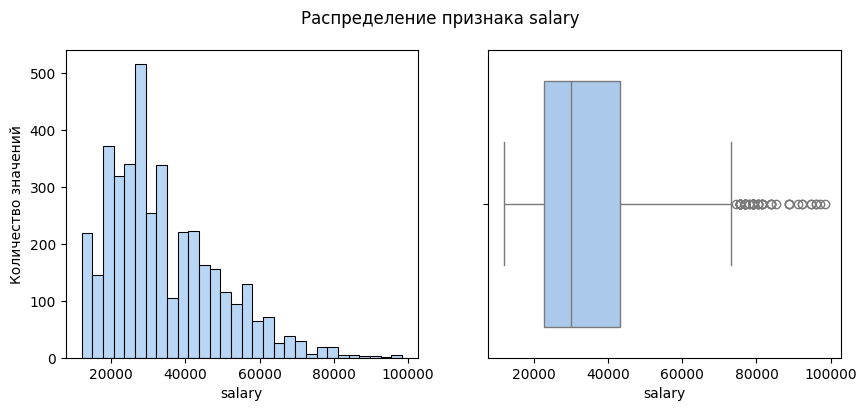

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


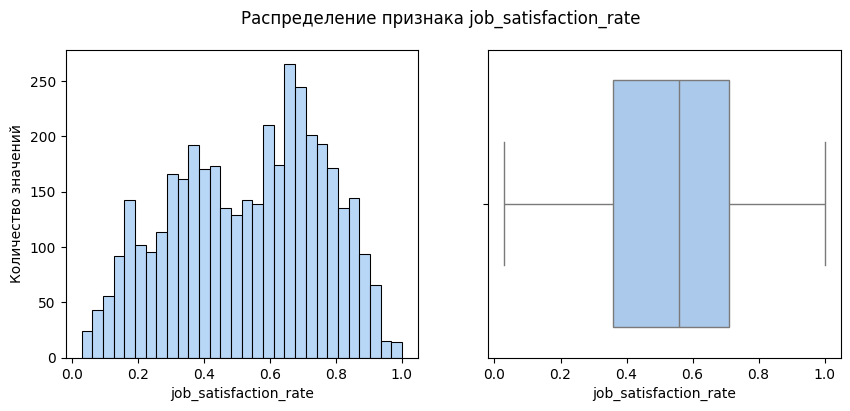

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


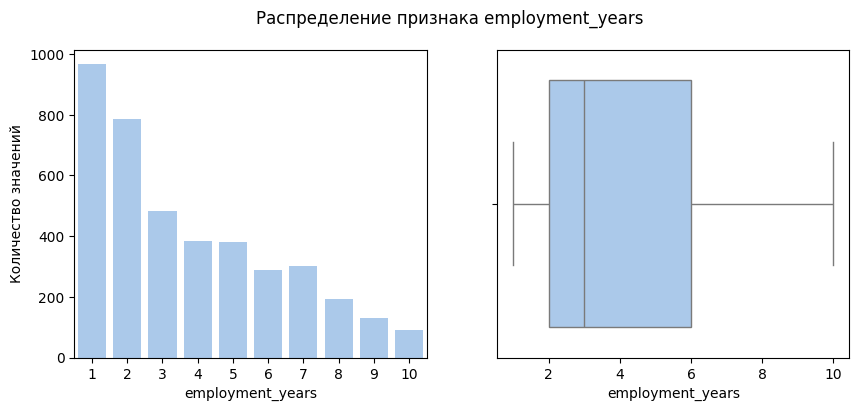

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


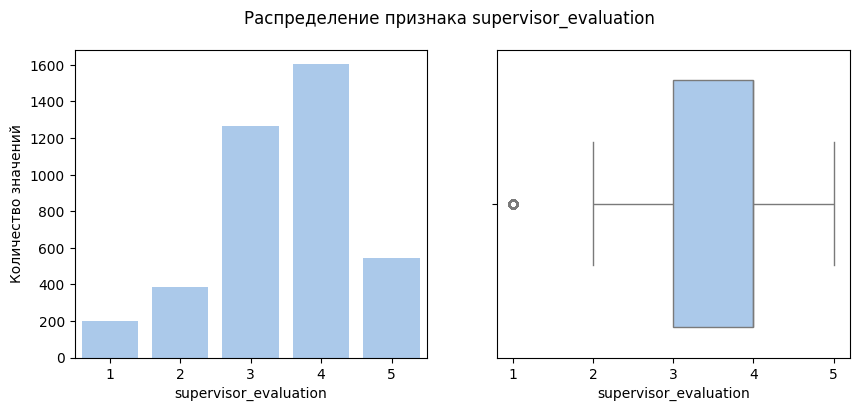

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


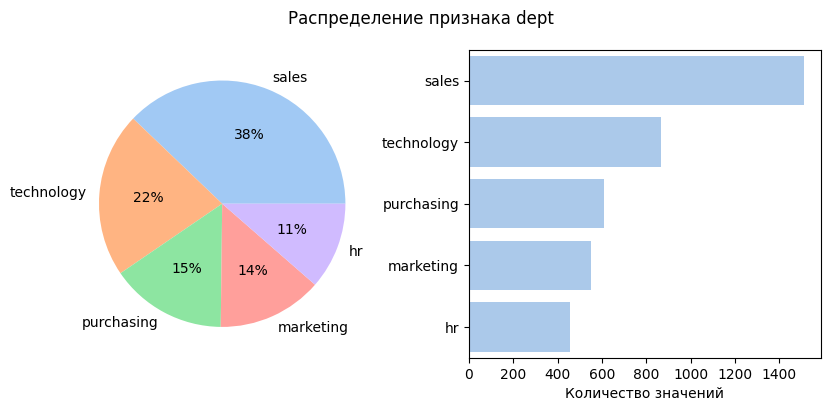

dept
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: count, dtype: int64


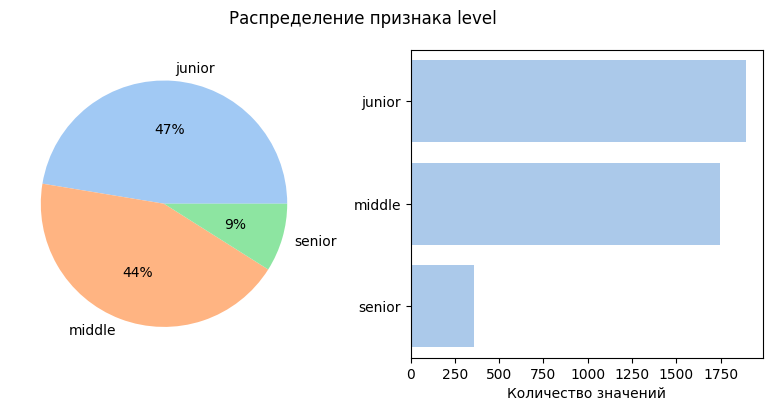

level
junior    1894
middle    1744
senior     358
Name: count, dtype: int64


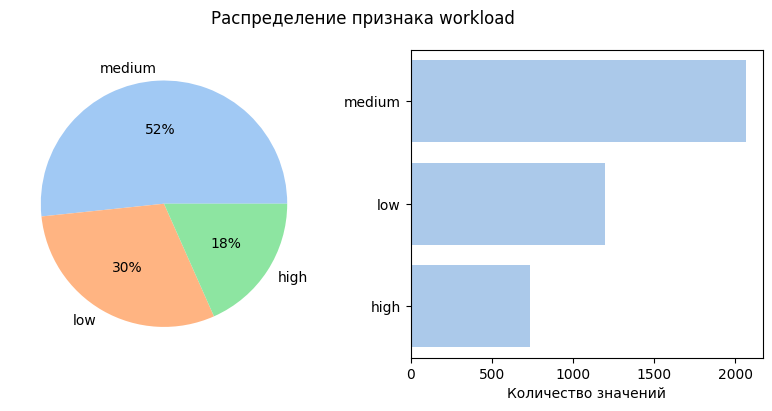

workload
medium    2066
low       1200
high       734
Name: count, dtype: int64


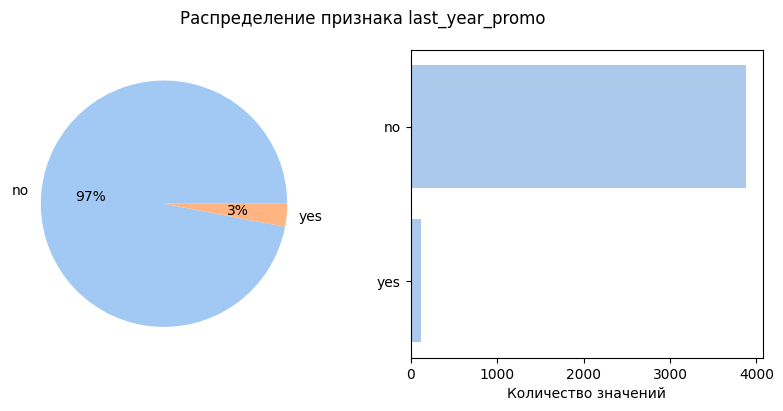

last_year_promo
no     3880
yes     120
Name: count, dtype: int64


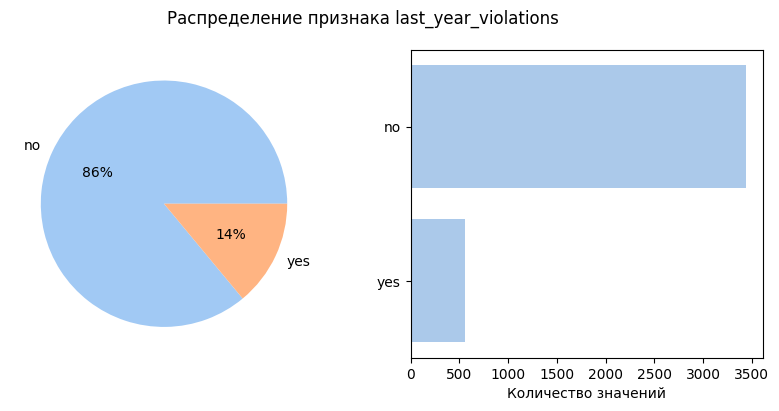

last_year_violations
no     3441
yes     559
Name: count, dtype: int64


In [31]:
# строим графики
table_plots(train_job_satisfaction_rate, continuous_cols, discrete_cols, category_cols)

Выводы по графикам:
- **salary:** Гистограмма имеет правостороннюю асимметрию, с основной концентрацией значений в диапазоне 25–45 тыс. Средняя зарплата 30-34 тыс. Встречаются и большие значения (более 77 тыс.), но их достаточно мало. У гистограммы есть несколько локальных пиков (например примерно 15, 20, 27 тыс. и тд), скорее всего они возникают из-за того что в компании базовые рабочие места различных отделов оплачиваются одинаково
- **job_satisfaction_rate:** Гистограмма имеет бимодальное распределение, это указывает на то, что есть 2 основные группы оценок сотрудников, возможно связанные с различными отделами или условиями работы. Большинство работников имеют удовлетворённость работой в диапазоне 0.4–0.7, что указывает на относительно устойчивую ситуацию в компании. Существуют сотрудники с очень низкой удовлетворённостью (<0.2), а также некоторые — очень высокую (>0.9), но встречаются достаточно редко
- **employment_years:** Стаж работы имеет правостороннюю асимметрию, число сотрудником уменьшается по мере увеличения стажа. Большинство сотрудников имеют небольшой стаж (до 3 лет), что может указывать на текучесть кадров или молодой состав команды. Встречаются и сотрудники с большим стажем работы в компании (более 8 лет)
- **supervisor_evaluation:** Гистограмма имеет левостороннюю ассиметрию, работников с оценкой 3, 4 большинство. Оценки 1 и 2 встречаются достаточно редко, в общем 600 значений из 4000 (15%), следовательно сотрудники в основном справляются со своими обязанностями. Также встречаются оценки 5, скорее всего они принадлежат опытным работникам, долго служащим в компании
- **dept:** Распределение сотрудников по отделам неравномерно. Самый большой отдел - отдел продаж, что указывает на его важность для компании, а самый маленький отдел - hr
- **level:** Распределение сотрудников по уровням неравномерно. Junior и Middle занимают больше 90% сотрудников, что указывает на преобладание молодого и среднего звена в компании. Senior-ов всего 9%, что является ожидаемым, так как очень опытных сотрудников не много в любой компании
- **workload:** Распределение работников по загруженности неравномерно. Больше половины сотрудников, работают в среднем режиме, меньше сотрудников работают в условиях низкой загруженности (30%), возможно это студенты или люди совмещающие эту работу с какой-либо еще. И оставшиеся 18% сильно загружены, что может стать причиной для снижения удовлетворённости работой в будущем
- **last_year_promo:** Компания имеет очень низкий уровень повышений среди сотрудников за последний год. Всего 3% работников получили повышение, это может указывать на низкий карьерный рост или строгие критерии для получения повышения в компании, что может влиять на их удовлетворённость работой
- **last_year_violations:** Компания имеет довольно низкий уровень нарушений трудового договора (всего 14% сотрудников имели нарушения), что говорит о хорошей дисциплине в компании.

#### 3.2 Таблица test_job_satisfaction_rate

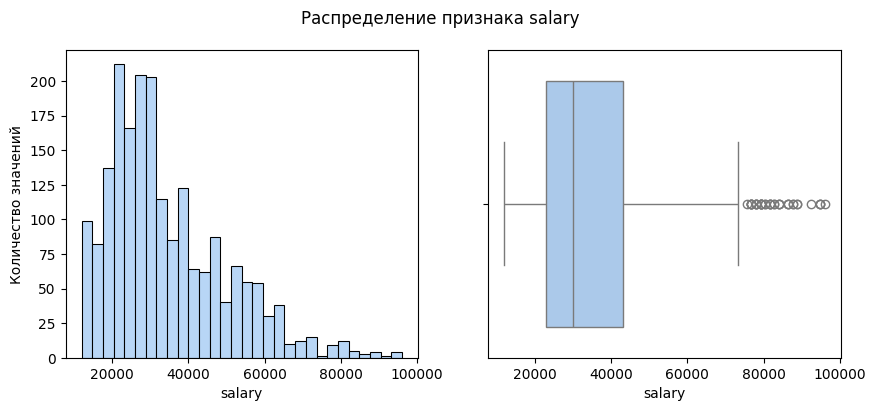

count     1998.000000
mean     34067.267267
std      15405.389599
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


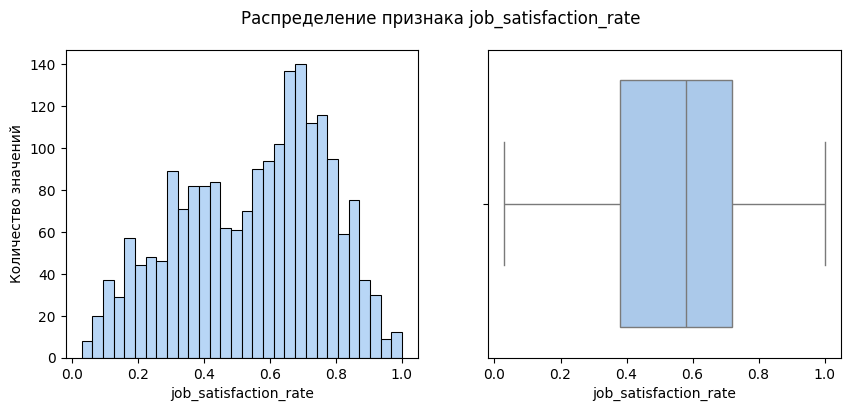

count    1998.000000
mean        0.548614
std         0.220144
min         0.030000
25%         0.380000
50%         0.580000
75%         0.720000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


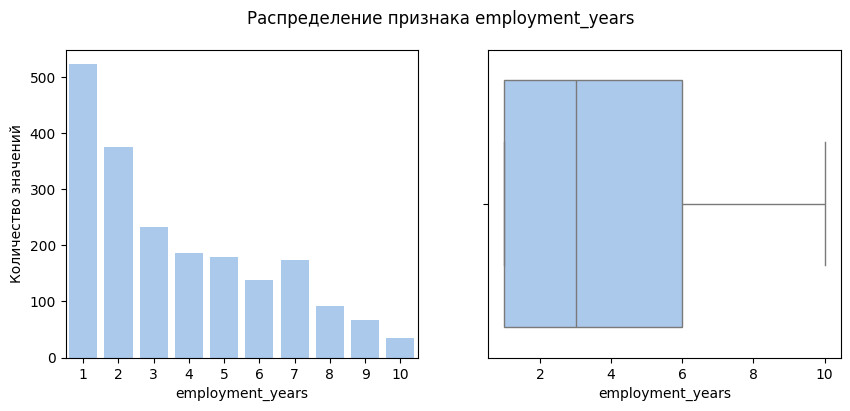

count    1998.000000
mean        3.666667
std         2.538438
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


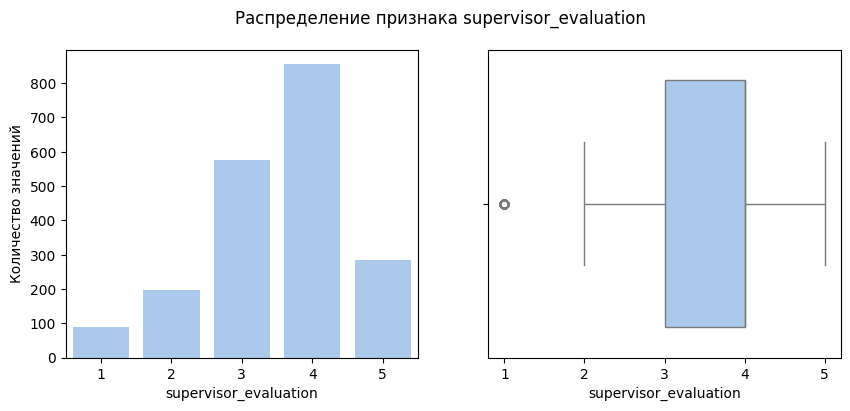

count    1998.000000
mean        3.526026
std         0.997279
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


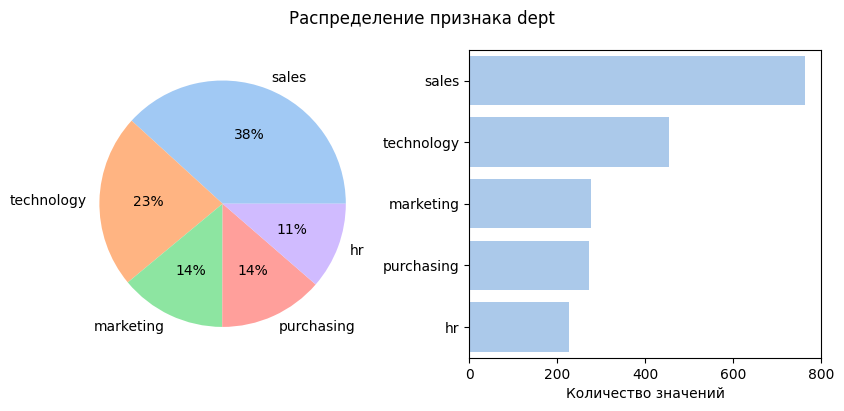

dept
sales         763
technology    455
marketing     278
purchasing    273
hr            227
Name: count, dtype: int64


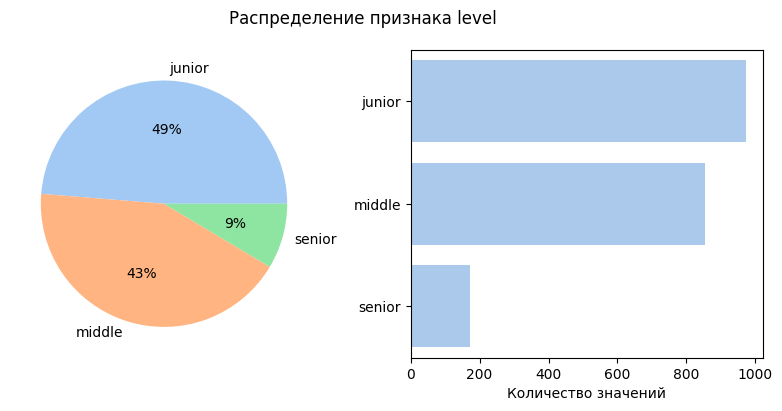

level
junior    973
middle    853
senior    171
Name: count, dtype: int64


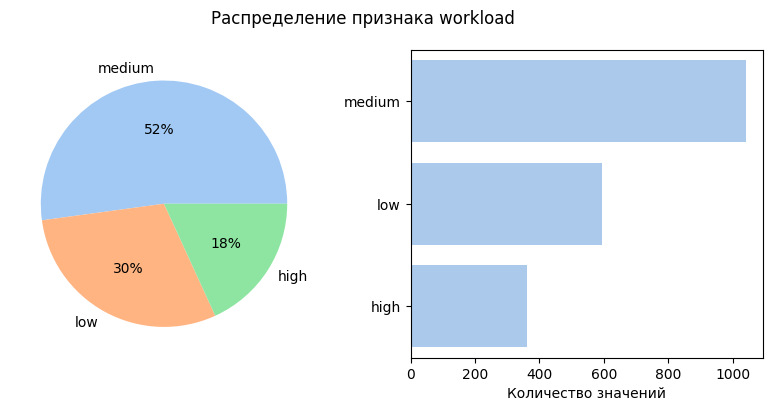

workload
medium    1042
low        593
high       363
Name: count, dtype: int64


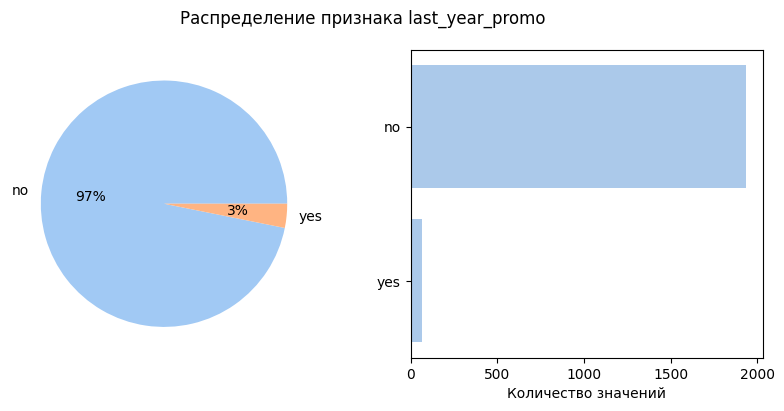

last_year_promo
no     1935
yes      63
Name: count, dtype: int64


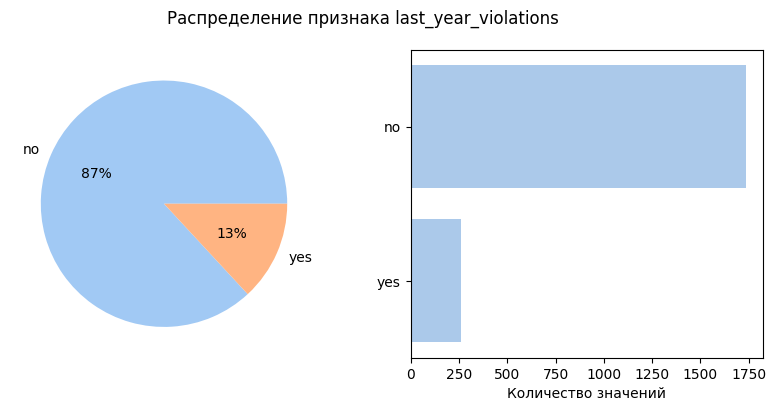

last_year_violations
no     1736
yes     262
Name: count, dtype: int64


In [32]:
table_plots(test_job_satisfaction_rate.query('dept!=" " and workload!=" "'), continuous_cols, discrete_cols, category_cols)

Все графики очень похожи на графики из предыдущей таблицы, что указывает на репрезентативность тестовой выборки. У таргета среднее и медианное значение выше чем в таблице `train_job_satisfaction_rate`, но незначительно (всего на 0.02)

#### 3.3 Корреляционный анализ

Проведем корреляционный анализ, чтобы изучить связь входных признаков с таргетом и выявить мультиколлинеарность (при наличии). Анализ будем проводить на основе таблицы `train_job_satisfaction_rate`, поскольку тестовая выборка имеет аналогичные тренды. Используем phik для подсчёта корреляции между признаками разных типов данных и построим матрицу корреляций

In [33]:
%%time

# считаем корреляции
phik_overview = phik_matrix(train_job_satisfaction_rate, interval_cols=['job_satisfaction_rate', 'salary']) 

CPU times: user 103 ms, sys: 122 ms, total: 225 ms
Wall time: 2.75 s


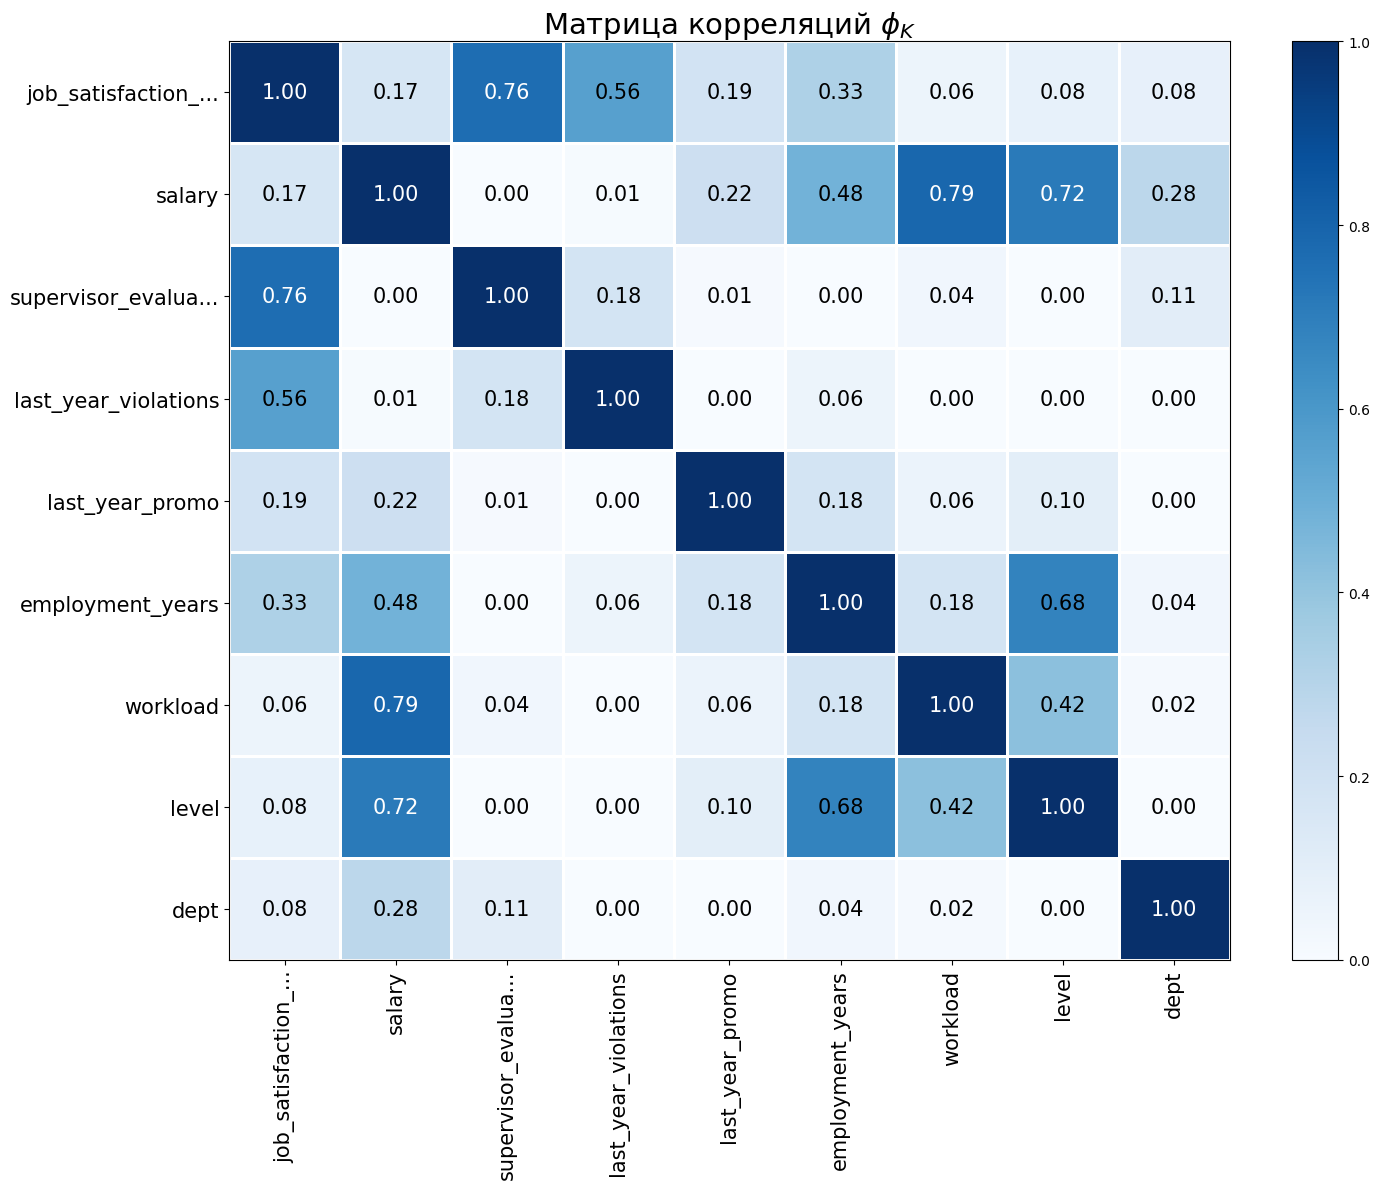

In [34]:
# строим матрицу корреляций
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'Матрица корреляций $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 12)
);

Можно заметить корреляции между целевым признаком (job_satisfaction_rate) и следующими признаками:
- Высокая корреляция:
    - supervisor_evaluation (оценка руководителя)
    - last_year_violations (нарушение трудового договора за последний год) 
- Средняя корелляция:
    - last_year_promo (получение повышения за последний год)
- Умеренная корелляция:
    - salary (зарплата)
    - employment_years (стаж работы)
- Низкая корелляция:
    - workload (уровень загруженности)
    - level (уровень должности)
    - dept (отдел)

Также поскольку между разными признаками нет слишком сильной корреляции (>0.9), мультиколлинеарных столбцов нет.

Данные можно разделить на 3 категории для подготовки к обучению:
- **числовые:** их нужно будет масштабировать, поскольку данные имеют слишком разные значения
- **категориальные упорядоченные:** *level* и *workload*, их будем кодировать с помощью OrdinalEncoder
- **категориальные неупорядоченные:** остальные категориальные признаки, их будем кодировать OneHotEncoder

**Промежуточный вывод:** В результате исследовательского анализа данных были изучены закономерности в распределении данных во всех таблицах, исследованы корреляции между признаками, а также сделаны выводы о том, как их нужно подготовить.

### 4 Подготовка данных

С помощью ColumnTransformer подготовим данные к обучению

In [35]:
# отделяем целевой признак 
X = train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y = train_job_satisfaction_rate['job_satisfaction_rate']

In [36]:
# разбиваем данные на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = 0.25, 
    random_state = 42,
    stratify = y
)

In [37]:
X_test = test_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_test = test_job_satisfaction_rate['job_satisfaction_rate']

In [38]:
# создаем списки стобцов для кодирования и масштабирования
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = [i for i in X_train.columns if X_train[i].dtype != 'object']

In [39]:
# создаем пайплайн для ohe
ohe_pipe = Pipeline(
    [
        ('imput_ohe', imput_pipe),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error')),
    ],
)

In [40]:
# создаем пайплайн для ord
ord_pipe = Pipeline(
    [
        ('imput_ord', imput_pipe),
        ('ord', OrdinalEncoder(
            categories=[
                ['junior', 'middle', 'senior'], 
                ['low', 'medium', 'high']
            ], 
            handle_unknown='use_encoded_value', unknown_value=np.nan
        )),
    ],
)

In [41]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns),
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns)
    ], 
    remainder='passthrough'
)

**Промежуточный вывод:** Написали пайплайны для подготовки данных к обучению

### 5 Обучение моделей

Для предсказания целевого признака будем использовать: линейную регрессию, дерево решений и svr. В качестве метрики будем использовать SMAPE

In [42]:
# функция счета smape
def smape(y_true, y_pred):
    return 100/len(y_true)*np.sum(2*np.abs(y_true-y_pred)/(np.abs(y_true)+np.abs(y_pred)))

In [43]:
# создаем счетчик метрики
smape_score = make_scorer(smape, greater_is_better=False)

In [44]:
# создаем финальный пайплайн с подготовкой и моделью
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [45]:
# словарь для сравнения моделей
results = {
    'model': ['linreg', 'tree', 'svr'],
    'smape': []
}

#### 5.1 Обучение модели линейной регрессии

Обучим модель линейной регрессии. Поскольку у нее нет гиперпараметров, будем подбирать способ масштабирования числовых данных

In [46]:
# словарь для подбора параметров для модели линрег
linreg_param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
}

In [47]:
%%time

# подбираем параметры
linreg_search = GridSearchCV(
    pipe_final, 
    linreg_param_grid, 
    cv=5,
    scoring=smape_score,
    n_jobs=-1
)
linreg_search.fit(X_train, y_train);

CPU times: user 115 ms, sys: 12.8 ms, total: 127 ms
Wall time: 664 ms


In [48]:
# сохраняем лучший предобработчик и модель в переменные
linreg_model = linreg_search.best_estimator_.named_steps['models']
linreg_preprocessor = linreg_search.best_estimator_.named_steps['preprocessor']

In [49]:
# добавляем в results значение метрики на валидационной выборке
results['smape'].append(smape_score(linreg_model, linreg_preprocessor.transform(X_val), y_val)*(-1))

#### 5.2 Обучение модели дерева решений

Для модели дерева решений будем подбирать следующие праметры:
- max_depth: максимальная глубина дерева
- max_features: максимальное количество характеристик, которые следует учитывать при разделении
- min_samples_split: минимальное количество примеров, необходимое для разделения узла
- min_samples_leaf: минимальное количество примеров, необходимое для создания листа

In [50]:
tree_param_grid = {
    'models': [DecisionTreeRegressor(random_state=42)],
    'models__max_depth': [None, 2, 3, 4, 5, 6, 7],
    'models__max_features': range(2,5),
    'models__min_samples_split': [2, 5, 10],
    'models__min_samples_leaf': range(1,5)
}

In [51]:
%%time
tree_search = RandomizedSearchCV(
    pipe_final, 
    tree_param_grid, 
    random_state=42,
    cv=5,
    scoring=smape_score,
    n_jobs=-1,
    n_iter=30
)
tree_search.fit(X_train, y_train);

CPU times: user 417 ms, sys: 23.4 ms, total: 440 ms
Wall time: 1.35 s


In [52]:
tree_model = tree_search.best_estimator_.named_steps['models']
tree_preprocessor = tree_search.best_estimator_.named_steps['preprocessor']

In [53]:
results['smape'].append(smape_score(tree_model, tree_preprocessor.transform(X_val), y_val)*(-1))

#### 5.3 Обучение модели svr

Для модели svr будем подбирать:
- C: параметр регуляризации
- kernel: тип ядра, который будет использоваться в алгоритме (линейное, Гаусово, полиномиальное)
- способ масштабирования числовых данных

In [54]:
svr_param_grid = {
    'models': [SVR()],
    'models__C': [0.1, 1, 10],
    'models__kernel': ['linear', 'rbf', 'poly'],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
}

In [55]:
%%time
svr_search = RandomizedSearchCV(
    pipe_final, 
    svr_param_grid, 
    random_state=42,
    cv=5,
    scoring=smape_score,
    n_jobs=-1,
    n_iter=10
)
svr_search.fit(X_train, y_train);

CPU times: user 406 ms, sys: 32.8 ms, total: 439 ms
Wall time: 8.48 s


In [56]:
svr_model = svr_search.best_estimator_.named_steps['models']
svr_preprocessor = svr_search.best_estimator_.named_steps['preprocessor']

In [57]:
results['smape'].append(smape_score(svr_model, svr_preprocessor.transform(X_val), y_val)*(-1))

#### 5.4 Сравнение моделей

Сравним модели по результатам метрики smape на тренировочной и тестовой выборках

In [58]:
# переводим словарь в датафрейм для красивого вывода
df_results = pd.DataFrame(results)
df_results.set_index('model').round(4)

,smape
model,
linreg,25.0104
tree,16.9496
svr,14.8190


Линейная регрессия показала наихудшие результаты по метрике SMAPE (25), она не подходит для данной задачи. Дерево решений показало неплохие результаты (16.9), но все же не прошло порог (15). SVR - наиболее точная модель, поскольку имеет наименьшее значение SMAPE на тестовой выборке (14.8), но время потраченое на подбор параметров выше чем у остальных моделей. 

Проверим лучшую модель на тестовой выборке, посчитав ее smape

In [59]:
print(f'smape на тестовой выборке: {smape_score(svr_model, svr_preprocessor.transform(X_test), y_test)*(-1)}')

smape на тестовой выборке: 13.954433660677834


**Промежуточный вывод:** Обучили 3 модели и сравнили их результаты. Для предсказания уровня удовлетворенности сотрудников будем использовать модель svr, поскольку она показала себя лучше остальных моделей

## Задача 2: предсказание увольнения сотрудника из компании

### 1 Загрузка данных

#### 1.1 Загрузка таблиц

`train_quit` - Тренировочная выборка для второй задачи

In [60]:
try:
    train_quit = pd.read_csv('datasets/train_quit.csv', index_col='id')
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv', index_col='id')

`test_features` - Входные данные тестовой выборки, те же, что и для первой задачи

`test_target_quit` - Целевой признак тестовой выборки для второй задачи

In [61]:
try:
    test_target_quit = pd.read_csv('datasets/test_target_quit.csv', index_col='id')
except:
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv', index_col='id')

#### 1.2 Общая информация

In [62]:
df_info(train_quit)

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no
699916,sales,junior,low,1,no,yes,3,18000,yes
417070,technology,middle,medium,8,no,no,2,44400,no
165489,sales,middle,low,4,no,no,5,19200,no
996399,marketing,middle,low,7,no,no,4,25200,no


In [63]:
df_info(test_target_quit)

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes
223063,no
810370,no
998900,no
578329,no


Изучив общую информацию о датафреймах, можно заметить следующее: 
 - В тестовой выборке другие работники
 - Пропусков нет
 - Идентификаторы таргета тестовой выборки снова не в том порядке, что входне признаки 

**Промежуточный вывод:** В результате загрузки данных, были загружены данные и получено общее представление об изучаемых данных, что упростит дальнейшую работу с ними.

### 2 Предобработка данных

#### 2.1 Объединение тестовой выборки

Объединим входные признаки и таргет тестовой выборки

In [64]:
# объединяем таблицы
test_quit = test_features.join(test_target_quit, how='left')

In [65]:
# проверяем
test_quit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
 8   quit                   2000 non-null   object
dtypes: int64(3), object(6)
memory usage: 220.8+ KB


Значений столько, сколько нужно, объединение прошло корректно

#### 2.2 Обработка пропусков

Явных пропусков в новых таблицах нет. Проверим есть ли неявные пропуски

In [66]:
object_unique(train_quit)

dept                : ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level               : ['middle' 'junior' 'sinior']
workload            : ['high' 'medium' 'low']
last_year_promo     : ['no' 'yes']
last_year_violations: ['no' 'yes']
quit                : ['no' 'yes']


In [67]:
object_unique(test_quit)

dept                : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level               : ['junior' 'middle' 'sinior' nan]
workload            : ['medium' 'low' 'high' ' ']
last_year_promo     : ['no' 'yes']
last_year_violations: ['no' 'yes']
quit                : ['no' 'yes']


Неявных пропусков в тестовой выборке нет, а для пропусков в тестовой мы уже писали пайплайн.

#### 2.3 Обработка дубликатов

Исправим опечатку в слове *senior*

In [68]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
test_quit['level'] = test_quit['level'].replace('sinior', 'senior')

In [69]:
print(f'''Уникальные значения level в тренировочной выборке: {train_quit['level'].unique()}
Уникальные значения level в тестовой выборке: {test_quit['level'].unique()}''')

Уникальные значения level в тренировочной выборке: ['middle' 'junior' 'senior']
Уникальные значения level в тестовой выборке: ['junior' 'middle' 'senior' nan]


Теперь проверим таблицы на дублирующиеся строки по значениям индексов

In [70]:
len(train_quit.index.unique())

4000

In [71]:
len(test_quit.index.unique())

2000

Полных дубликатов нет

**Промежуточный вывод:** В результате предобработки данных, были объединены входные признаки и таргет тестовой выборки, обработаны пропуски в таблицах и дубликаты, что облегчит дальнейшую работу с данными

### 3 Исследовательский анализ данных

Используем функцию для построения графиков и анализа, которую написали в первой задаче

#### 3.1 Таблица train_quit

In [72]:
continuous_cols = ['salary']
discrete_cols = ['employment_years', 'supervisor_evaluation']
category_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']

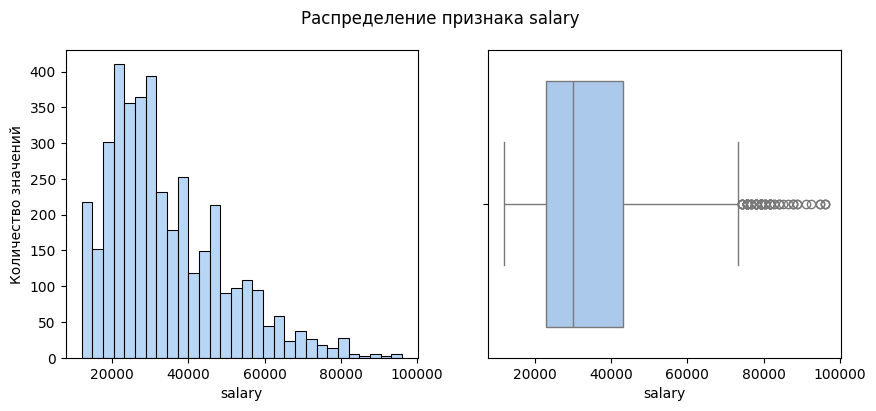

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


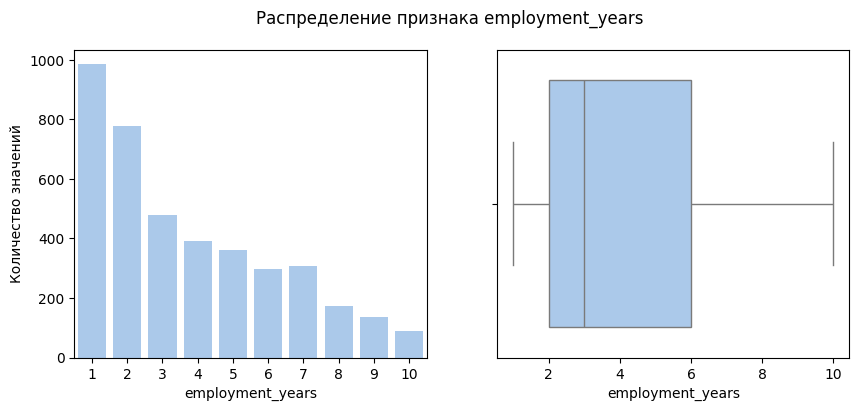

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


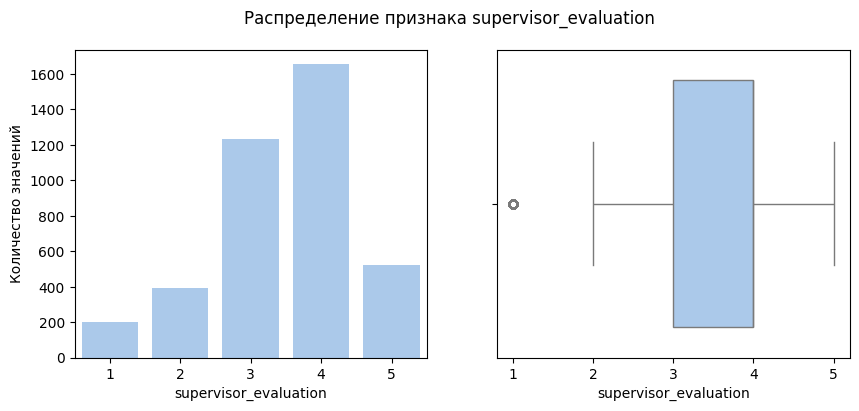

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


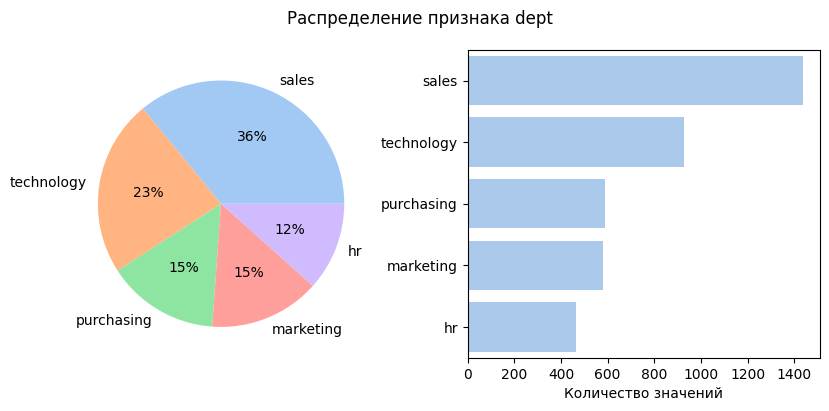

dept
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: count, dtype: int64


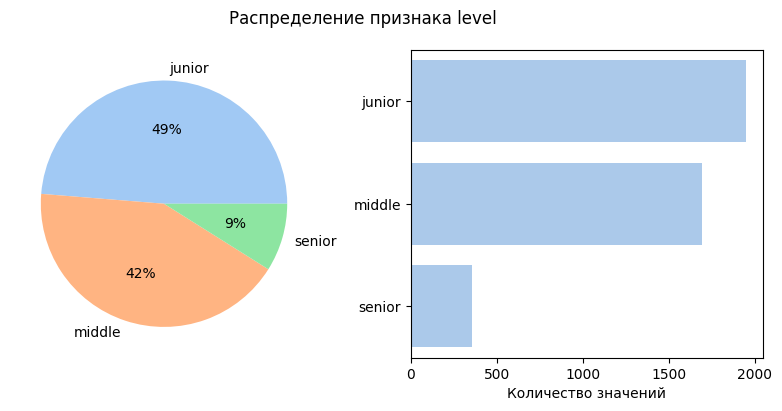

level
junior    1949
middle    1694
senior     357
Name: count, dtype: int64


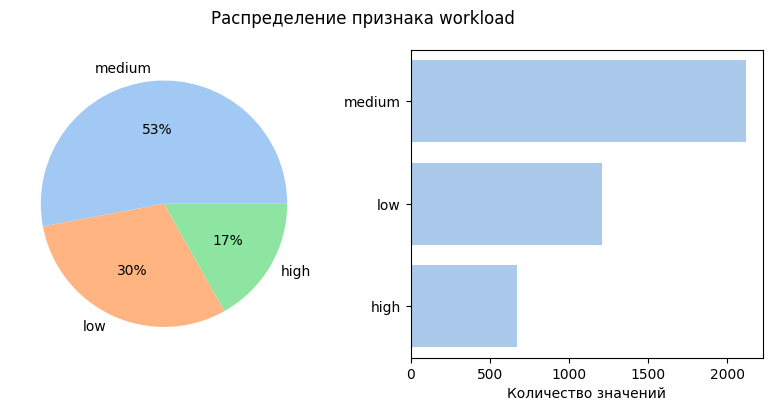

workload
medium    2118
low       1208
high       674
Name: count, dtype: int64


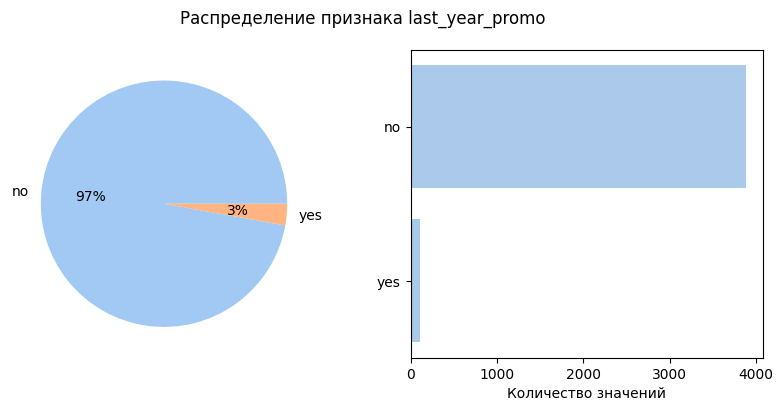

last_year_promo
no     3887
yes     113
Name: count, dtype: int64


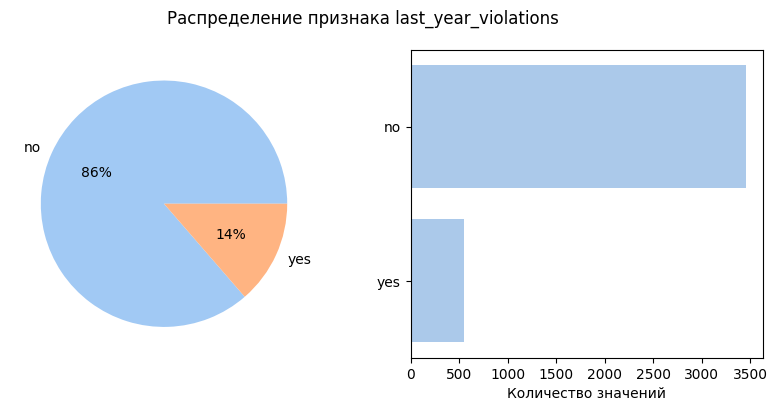

last_year_violations
no     3455
yes     545
Name: count, dtype: int64


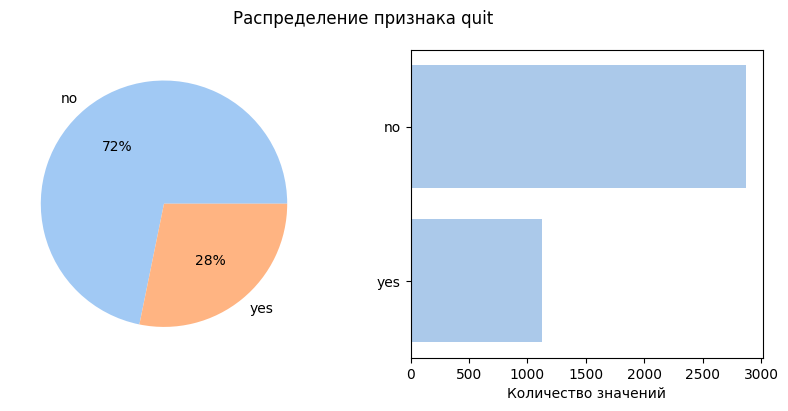

quit
no     2872
yes    1128
Name: count, dtype: int64


In [73]:
table_plots(train_quit, continuous_cols, discrete_cols, category_cols)

Все графики, кроме увольнений, аналогичны тренировочной выборке для первой задачи. Присутствует достаточно сильный дисбаланс классов, увольнения на высоком уровне: 28% работников покинули компанию, а это больше 1100 значений в данном случае, что очень много

#### 3.2 Таблица test_quit

Поскольку мы уже анализировали входные признаки, посмотрим только на тагрет

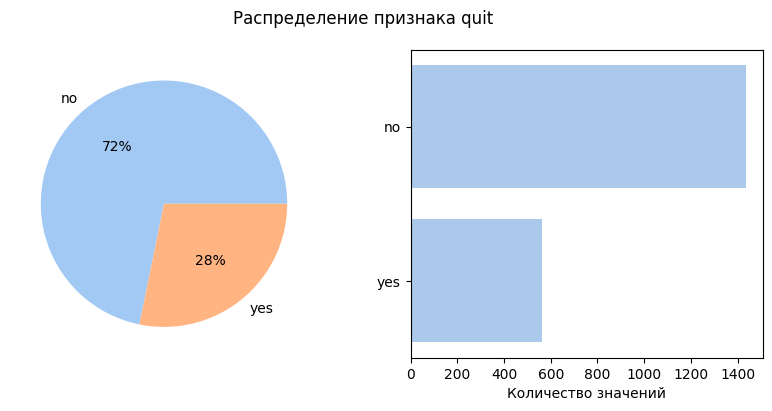

quit
no     1436
yes     564
Name: count, dtype: int64


In [74]:
category_plots(test_quit['quit'])

Таргет распределен аналогично тестовой выборке

#### 3.3 Портрет «уволившегося сотрудника»

Для того чтобы составить портрет уволившегося сотрудника, изучим зависимости увольнений от:
- отдела, в котором работает сотрудник
- занимаемого уровня должности сотрудника
- уровня загруженности сотрудника
- длительности работы в компании
- наличия повышения за последний год
- наличия нарушений трудового договора за последний год
- оценки качества работы сотрудника, которую дал руководитель
- ежемесячной зарплаты
- уровня удовлетворённости сотрудника работой в компании

In [75]:
# делаем сводную таблицу с количеством оставшихся и уволившихся работников по отделам
quit_dept = (train_quit
    .pivot_table(index='dept', columns='quit', values='level', aggfunc='count')
    .loc[['sales', 'purchasing', 'marketing', 'technology', 'hr']])

# добавляем долю уволившихся
quit_dept['Уволилось(%)'] = (quit_dept['yes']/(quit_dept['no']+quit_dept['yes'])*100).round(2)
quit_dept.columns = ['Уволилось', 'Не уволилось', 'Уволилось(%)']

In [76]:
quit_level = (train_quit.pivot_table(index='level', columns='quit', values='workload', aggfunc='count'))
quit_level['Уволилось(%)'] = (quit_level['yes']/(quit_level['no']+quit_level['yes'])*100).round(2)
quit_level.columns = ['Уволилось', 'Не уволилось', 'Уволилось(%)']

In [77]:
quit_workload = (train_quit
    .pivot_table(index='workload', columns='quit', values='level', aggfunc='count')
    .loc[['low', 'medium', 'high']])
quit_workload['Уволилось(%)'] = (quit_workload['yes']/(quit_workload['no']+quit_workload['yes'])*100).round(2)
quit_workload.columns = ['Уволилось', 'Не уволилось', 'Уволилось(%)']

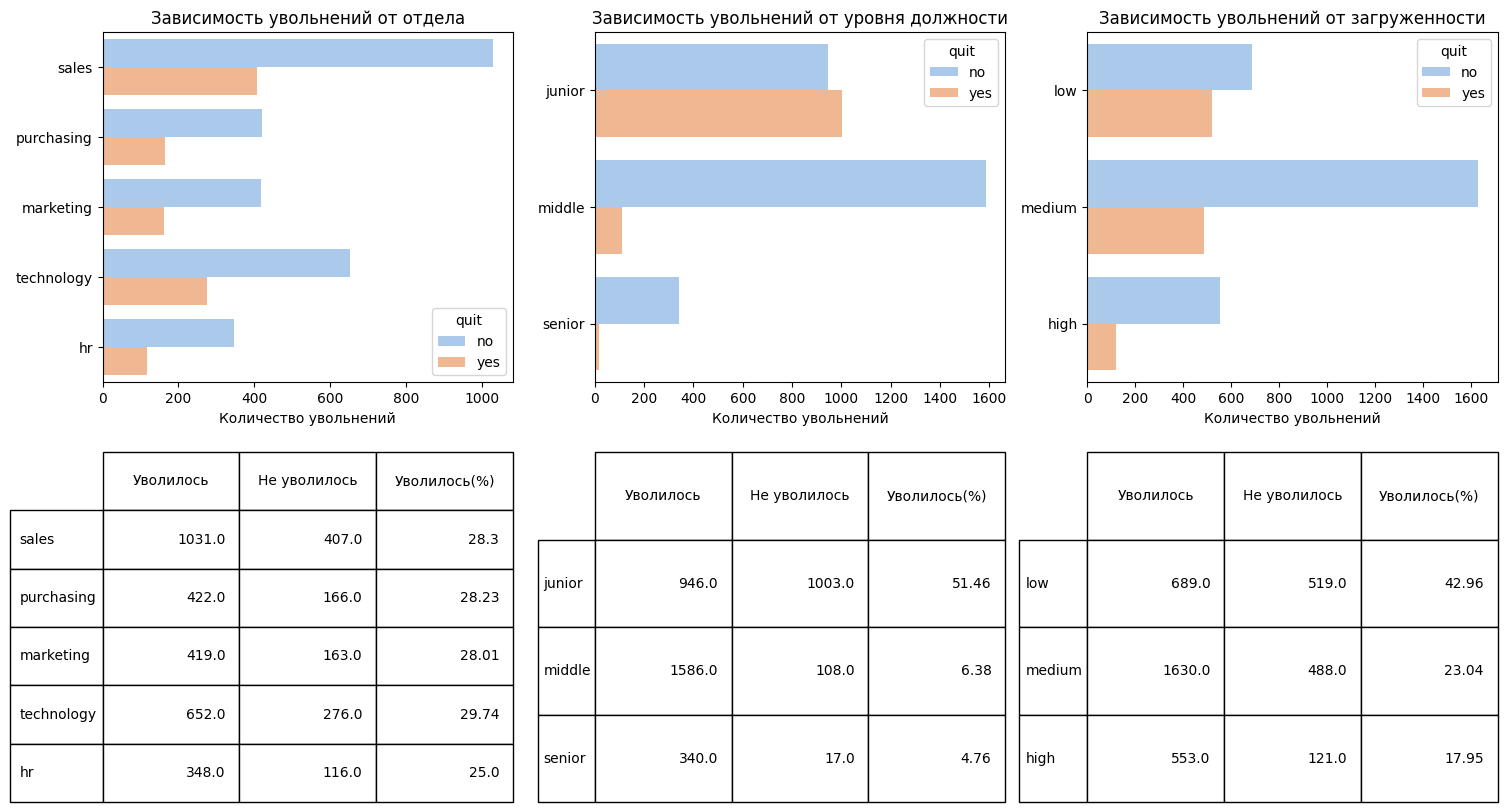

In [78]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# график зависимости увольнений от отдела
sns.countplot(data=train_quit, hue='quit', y='dept', ax=axes[0][0])
axes[0][0].set_title('Зависимость увольнений от отдела')
axes[0][0].set_xlabel('Количество увольнений')
axes[0][0].set_ylabel('')

# график зависимости увольнений от уровня должности
sns.countplot(data=train_quit, hue='quit', y='level', order=['junior', 'middle', 'senior'], ax=axes[0][1])
axes[0][1].set_title('Зависимость увольнений от уровня должности')
axes[0][1].set_xlabel('Количество увольнений')
axes[0][1].set_ylabel('')

# график зависимости увольнений от уровня загруженности
sns.countplot(data=train_quit, hue='quit', y='workload', order=['low', 'medium', 'high'], ax=axes[0][2])
axes[0][2].set_title('Зависимость увольнений от загруженности')
axes[0][2].set_xlabel('Количество увольнений')
axes[0][2].set_ylabel('')

# рисуем таблицы
axes[1][0].axis('off')
axes[1][0].table(quit_dept, bbox=[0, 0, 1, 1])

axes[1][1].axis('off')
axes[1][1].table(quit_level, bbox=[0, 0, 1, 1])

axes[1][2].axis('off')
axes[1][2].table(quit_workload, bbox=[0, 0, 1, 1]);

**Выводы по графикам:** 
- Отдел: доли уволившихся сотрудников очень близки для разных отделов, разница между максимальным и минимальным значением 4.74 процента, можно сделать вывод что отдел не влияет на увольнение
- Уровень дожности: видна значительная разница между уровнями, джуны покидают место работы более чем в половине случаев, для уровней повыше (мидл и сеньор) доля уволившихся сильно ниже (6.38% и 4.76% соответственно), скорее всего компании важны специалисты такого уровня и у них лучшие условия работы, по сравнению с джунами
- Уровень загруженности: тут также есть разница между классами, у сотрудников с низкой нагрузкой наибольшая доля увольнений (почти 43%), возможно работа в компании для них неосновная или подработка, и они увольняются когда в этой работе пропадает необходимость. Для средней нагрузки доля 23%, а для высокой почти 18%, что тоже достаточно много.

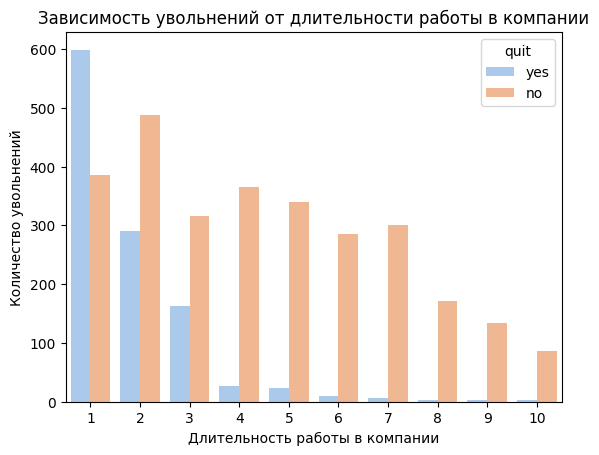

employment_years,1,2,3,4,5,6,7,8,9,10
Уволилось,599.00,290.00,163.00,27.00,23.00,10.00,7.00,3.00,3.00,3.00
Не уволилось,386.00,487.00,316.00,366.00,339.00,286.00,301.00,171.00,133.00,87.00
Уволилось(%),60.81,37.32,34.03,6.87,6.35,3.38,2.27,1.72,2.21,3.33


In [79]:
sns.countplot(data=train_quit, x='employment_years', hue='quit')
plt.title('Зависимость увольнений от длительности работы в компании')
plt.xlabel('Длительность работы в компании')
plt.ylabel('Количество увольнений')
plt.show()

quit_emp_years = (train_quit.pivot_table(index='quit', columns='employment_years', values='level', aggfunc='count'))
quit_emp_years.loc['Уволилось(%)'] = (quit_emp_years.loc['yes']/(quit_emp_years.loc['no']+quit_emp_years.loc['yes'])*100).round(2)
quit_emp_years.index=['Не уволилось', 'Уволилось', 'Уволилось(%)']
quit_emp_years.loc[['Уволилось', 'Не уволилось', 'Уволилось(%)']]

**Выводы по графику:** 

Наибольший отток среди сотрудников, которые устроились год назад (60%), работники со стажем 2 и 3 года увольняются в 34-37% случаев, далее доля уволившихся сидльно палает и не превышает 7%. Таким образом, сотрудники с коротким стажем работы (менее 3 лет) имеют значительно больший риск увольнения, чем те, кто работает дольше. Это может быть связано с адаптационным периодом или неудовлетворённостью условиями работы.

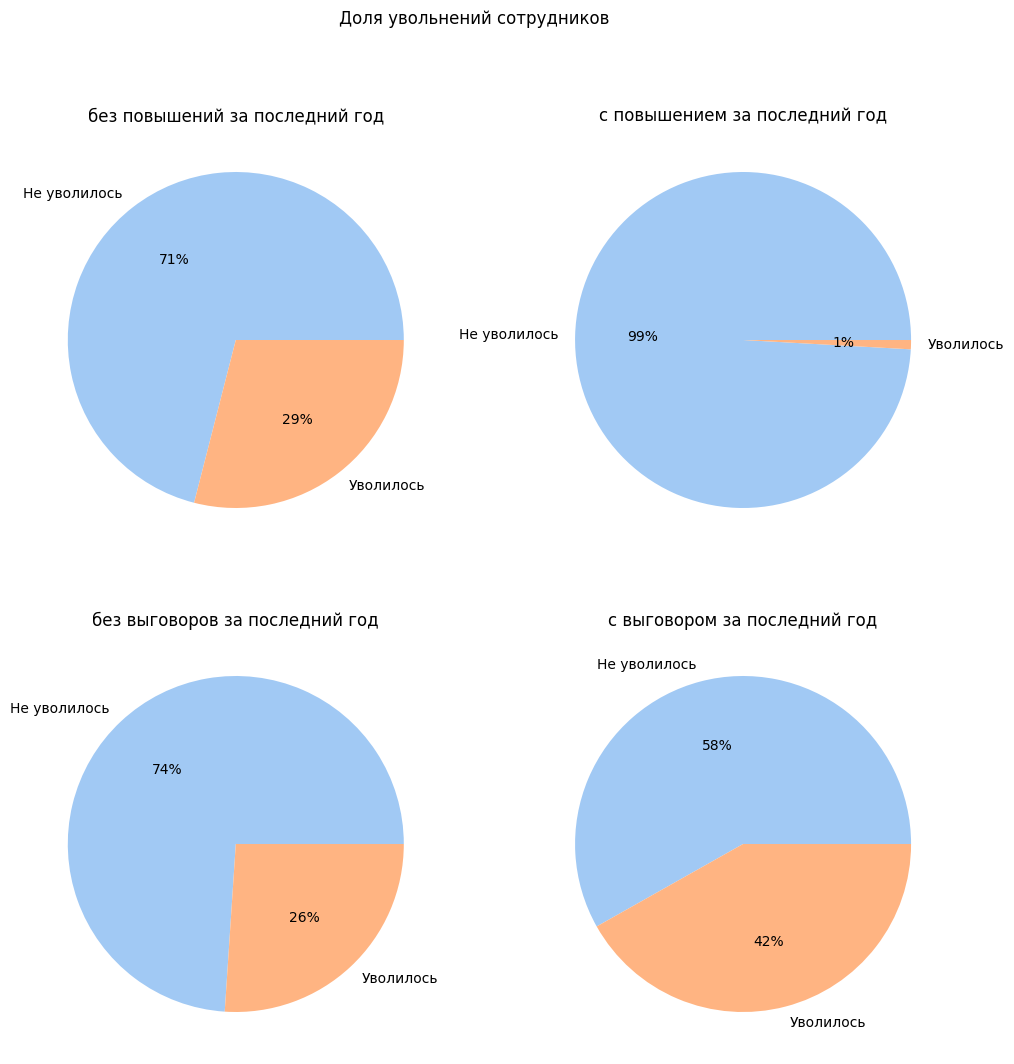

In [80]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
fig.suptitle('Доля увольнений сотрудников')

(train_quit
    .query('last_year_promo=="no"')['quit']
    .map({'no': 'Не уволилось', 'yes': 'Уволилось'})
    .value_counts()
    .plot(kind='pie', autopct='%1.0f%%', ax=axes[0][0]))
axes[0][0].set_title('без повышений за последний год')
axes[0][0].set_ylabel('')

(train_quit
    .query('last_year_promo=="yes"')['quit']
    .map({'no': 'Не уволилось', 'yes': 'Уволилось'})
    .value_counts()
    .plot(kind='pie', autopct='%1.0f%%', ax=axes[0][1])
)
axes[0][1].set_title('с повышением за последний год')
axes[0][1].set_ylabel('')

(train_quit
    .query('last_year_violations=="no"')['quit']
    .map({'no': 'Не уволилось', 'yes': 'Уволилось'})
    .value_counts()
    .plot(kind='pie', autopct='%1.0f%%', ax=axes[1][0]))
axes[1][0].set_title('без выговоров за последний год')
axes[1][0].set_ylabel('')

(train_quit
    .query('last_year_violations=="yes"')['quit']
    .map({'no': 'Не уволилось', 'yes': 'Уволилось'})
    .value_counts()
    .plot(kind='pie', autopct='%1.0f%%', ax=axes[1][1])
)
axes[1][1].set_title('с выговором за последний год')
axes[1][1].set_ylabel('');

**Выводы по графикам:**
- Повышение: получение повышения является мощным фактором удержания сотрудников, всего 1% служащих покинули компанию после получения повышения за последний год. Работники, которые не получили повышения, гораздо чаще покидают компанию (в 29% случаев)
- Выговор: получение выговора значительно увеличивает риск увольнения, 42% сотрудников покинули компанию после получения выговора в последнем рабочем году, против 26% покинувших без выговора, следовательно конфликтные ситуации или нарушения трудовой дисциплины могут привести к оттоку персонала

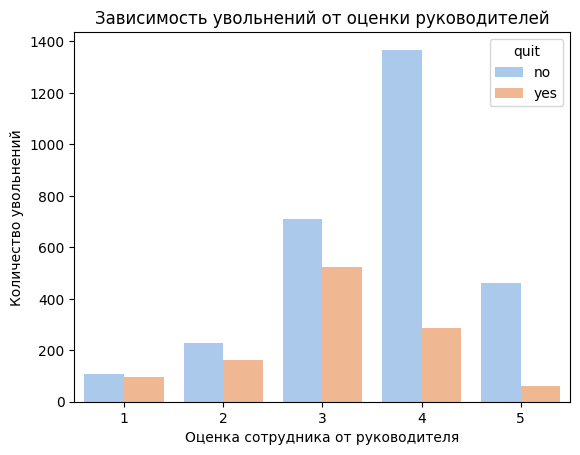

supervisor_evaluation,1,2,3,4,5
Уволилось,95.00,164.00,523.00,286.00,60.00
Не уволилось,107.00,227.00,710.00,1368.00,460.00
Уволилось(%),47.03,41.94,42.42,17.29,11.54


In [81]:
sns.countplot(data=train_quit, x='supervisor_evaluation', hue='quit')
plt.title('Зависимость увольнений от оценки руководителей')
plt.xlabel('Оценка сотрудника от руководителя')
plt.ylabel('Количество увольнений')
plt.show()

quit_sup_ev = (train_quit
    .pivot_table(index='quit', columns='supervisor_evaluation', values='level', aggfunc='count'))
quit_sup_ev.loc['Уволилось(%)'] = (quit_sup_ev.loc['yes']/(quit_sup_ev.loc['no']+quit_sup_ev.loc['yes'])*100).round(2)
quit_sup_ev.index=['Не уволилось', 'Уволилось', 'Уволилось(%)']
quit_sup_ev.loc[['Уволилось', 'Не уволилось', 'Уволилось(%)']]

**Выводы по графикам:**
У сотрудников с оценками 1-3, достаточно высокий риск увольнения (42-47%), а сотрудники с оценками 4 и 5 увольняются сильно реже (17.3% и 11.5% соответсвенно). Таким образом, сотрудники получившие более низкие оценки от руководителя, увольняются чаще

In [82]:
quit_salary = train_quit.groupby('quit')['salary'].describe().T
quit_salary.columns = ['Действующие', 'Уволившиеся']

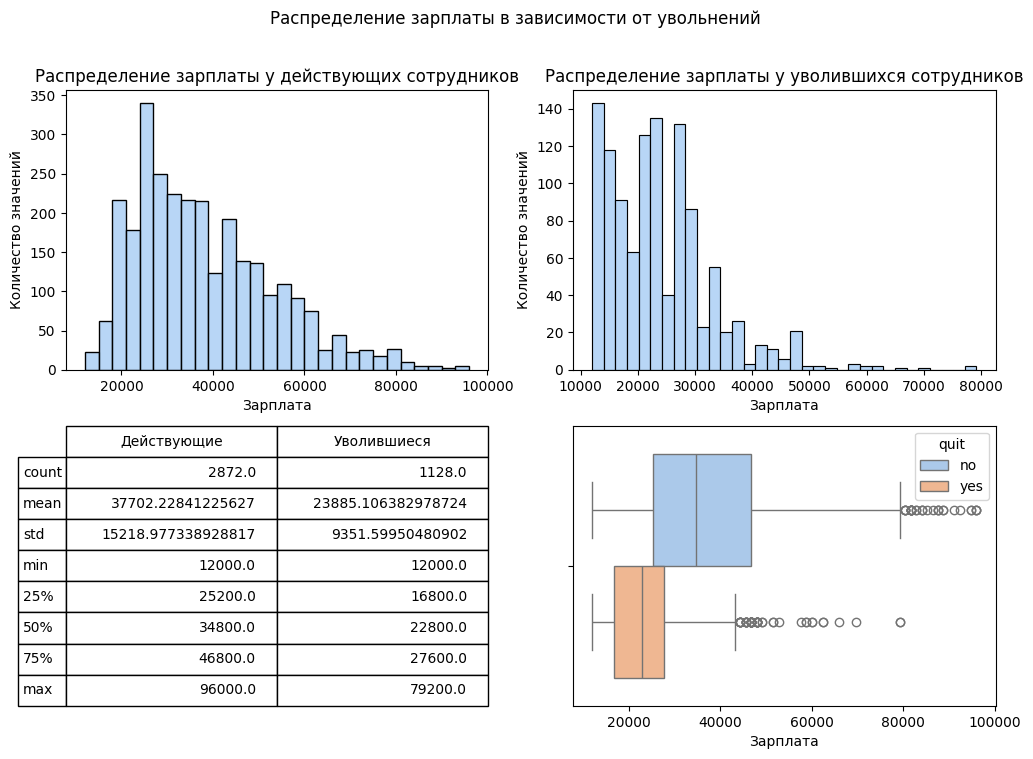

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Распределение зарплаты в зависимости от увольнений')

sns.histplot(train_quit.query('quit=="no"')['salary'], ax=axes[0][0])
axes[0][0].set_title('Распределение зарплаты у действующих сотрудников')
axes[0][0].set_xlabel('Зарплата')
axes[0][0].set_ylabel('Количество значений')

sns.histplot(train_quit.query('quit=="yes"')['salary'], ax=axes[0][1])
axes[0][1].set_title('Распределение зарплаты у уволившихся сотрудников')
axes[0][1].set_xlabel('Зарплата')
axes[0][1].set_ylabel('Количество значений')

axes[1][0].axis('off')
axes[1][0].table(quit_salary, bbox=[0, 0, 1, 1])

sns.boxplot(data=train_quit, hue='quit', x='salary', ax=axes[1][1])
axes[1][1].set_xlabel('Зарплата');

**Выводы по графикам:**
У действующих сотрудников зарплата выше, чем у уволившихся, это подтверждается распределением зарплат уволившихся, смещенным влево (к более низким зарплатам), относительно распределения действующих сотрудников, которое имеет более нормальное распределение. Также медианное и среднее значение у уволившихся сильно ниже, примерно на 12-15 тысяч. Таким образом, сотрудники с более низкой зарплатой имеют высокий риск увольнения, возможно это связано с низкой мотивацией к работе

С помощью модели svm предскажем параметр *job_satisfaction_rate* и изучим его связь с увольнением

In [84]:
train_quit['job_satisfaction_rate'] = svr_model.predict(svr_preprocessor.transform(train_quit))

In [85]:
quit_job_satisfaction_rate = train_quit.groupby('quit')['job_satisfaction_rate'].describe().T
quit_job_satisfaction_rate.columns = ['Действующие', 'Уволившиеся']

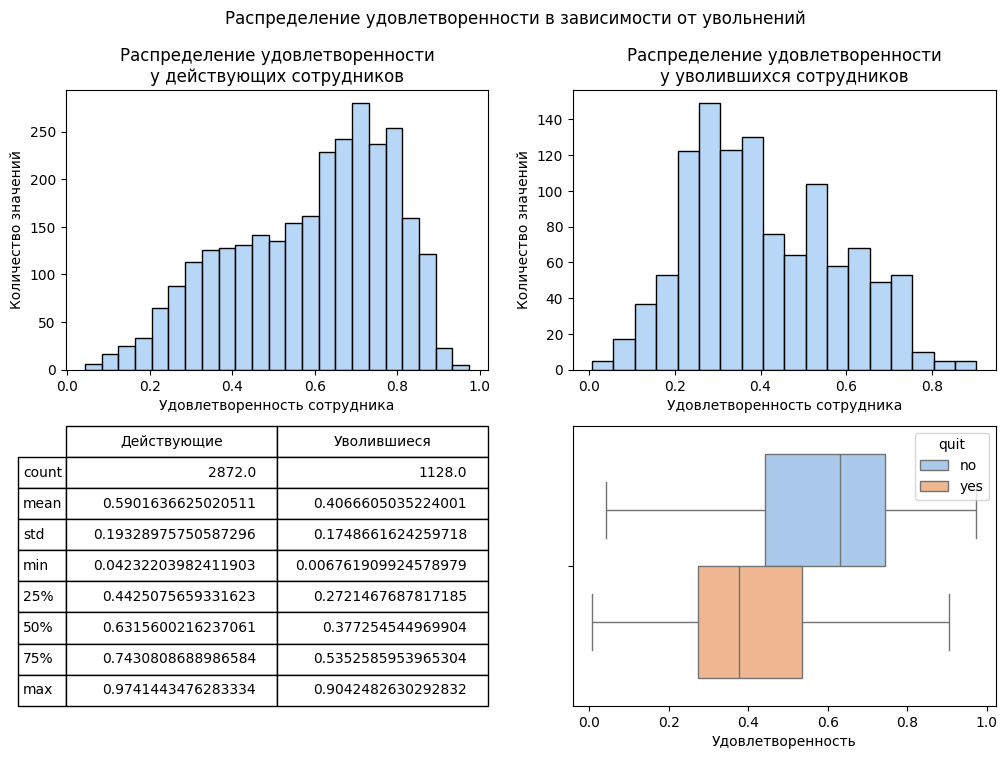

In [86]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Распределение удовлетворенности в зависимости от увольнений')

sns.histplot(train_quit.query('quit=="no"')['job_satisfaction_rate'], ax=axes[0][0])
axes[0][0].set_title('Распределение удовлетворенности\nу действующих сотрудников')
axes[0][0].set_xlabel('Удовлетворенность сотрудника')
axes[0][0].set_ylabel('Количество значений')

sns.histplot(train_quit.query('quit=="yes"')['job_satisfaction_rate'], ax=axes[0][1])
axes[0][1].set_title('Распределение удовлетворенности\nу уволившихся сотрудников')
axes[0][1].set_xlabel('Удовлетворенность сотрудника')
axes[0][1].set_ylabel('Количество значений')

axes[1][0].axis('off')
axes[1][0].table(quit_job_satisfaction_rate, bbox=[0, 0, 1, 1])

sns.boxplot(data=train_quit, hue='quit', x='job_satisfaction_rate', ax=axes[1][1])
axes[1][1].set_xlabel('Удовлетворенность');

**Выводы по графикам:**
У действующих сотрудников средняя удовлетворённость примерно 0.6, а у уволившихся  — 0.4, а также медиана удовлетворённости у уволившихся работников значительно ниже, чем у действующих. Таким образом, сотрудники с более низкой удовлетворённостью чаще покидают компанию

Также изучим корреляционную связь признаков с таргетом

In [87]:
%%time

phik_overview = phik_matrix(train_quit, interval_cols=['job_satisfaction_rate']) 

CPU times: user 65.5 ms, sys: 9.67 ms, total: 75.2 ms
Wall time: 115 ms


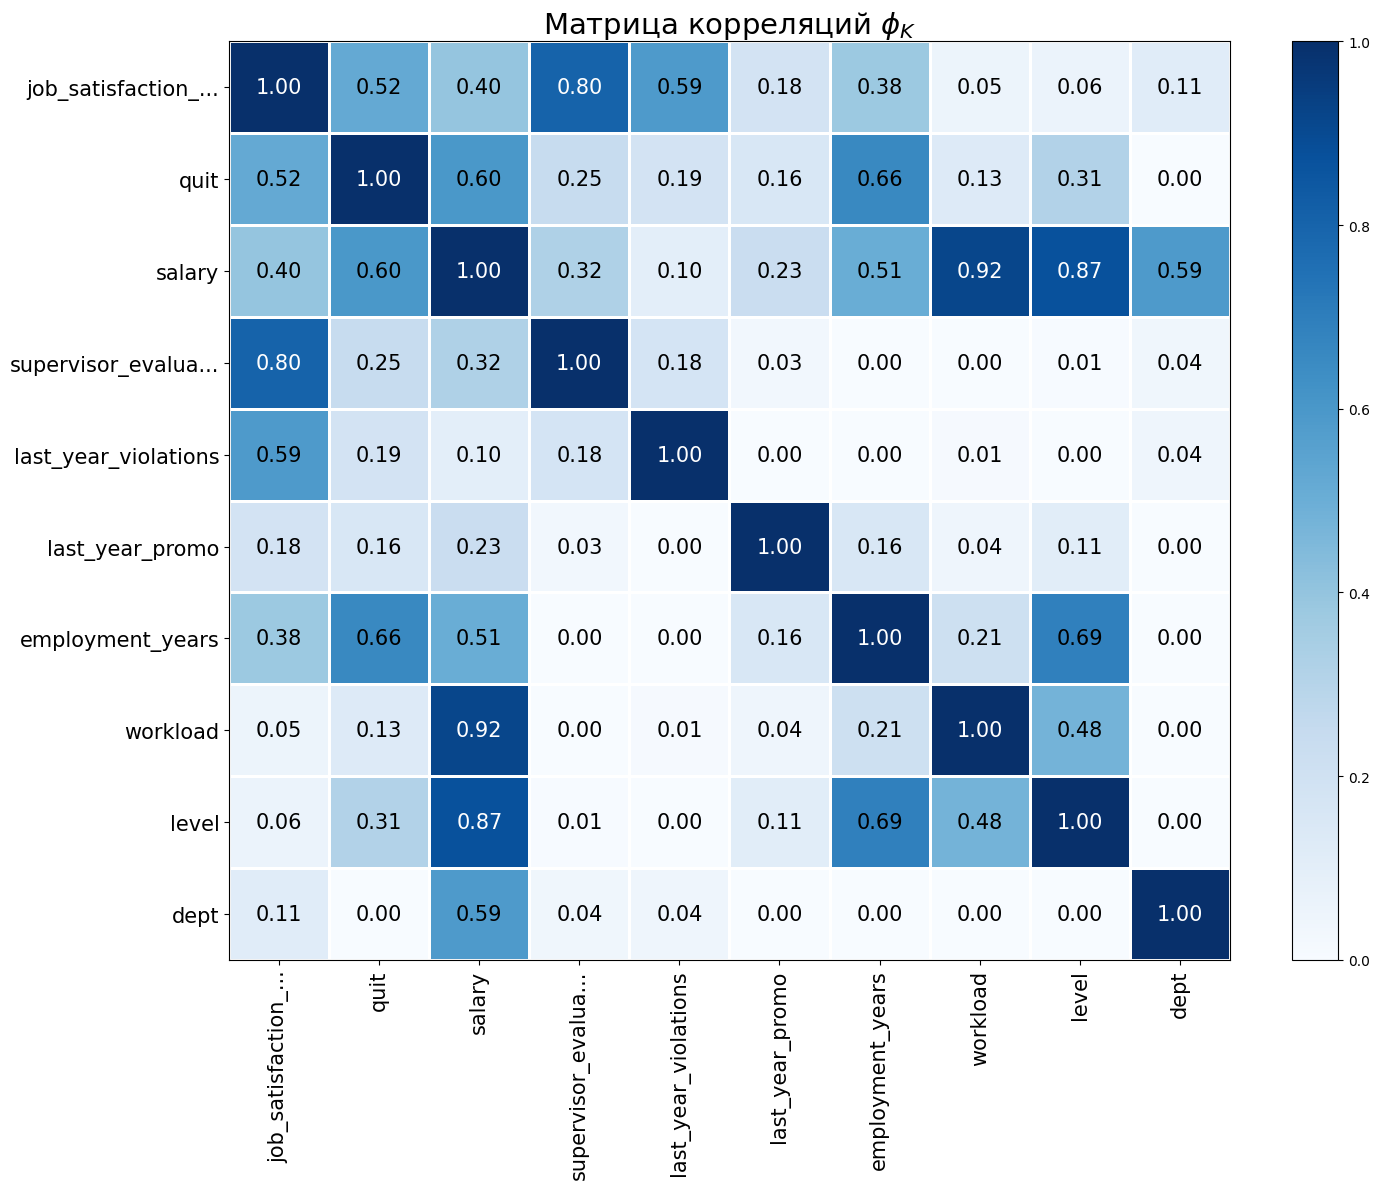

In [88]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'Матрица корреляций $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 12)
);

Таргет достаточно сильно коррелирует с salary (зарплата), employment_years (стаж работы) и job_satisfaction_rate (удовлетворенность работой), с dept (отдел) корелляция вовсе отсутствует, а с остальными признаками у таргета умеренная корелляция

Соберем сделанные выводы вместе и составим портрет *уволившегося сотрудника*:
- **отдел:** сотрудник может работать в любом отделе
- **уровень должности:** чаще всего junior, иногда middle
- **уровень загруженности:** низкая или средняя
- **длительность работы в компании:** до 3х лет
- **наличие повышения за последний год:** нет
- **наличие нарушений трудового договора за последний год:** не обязательно, но при наличии сильно повышает шансы увольнения
- **оценка качества работы сотрудника:** 1-3
- **зарплата:** ниже средней (до 40 тыс.)
- **уровень удовлетворённости сотрудника работой в компании:** ниже среднего

**Промежуточный вывод:** В результате исследовательского анализа данных были изучены закономерности в распределении данных во всех таблицах, исследованы зависимости между входными признаками и целевым, корреляция между признаками, а также составлен портрет уволившегося сотрудника

### 4 Добавление нового входного признака

Поскольку удовлетворенность влияет на то, уволится ли сотрудник, добавим job_satisfaction_rate, предсказанный  моделью svr, к входным признакам. В тренировочной выборке уже есть этот признак, поскольку мы его добавили во время исследовательского анализа, добавим уровень удовлетворенности к тестовой выборке

In [89]:
test_quit['job_satisfaction_rate'] = svr_model.predict(svr_preprocessor.transform(test_quit))

In [90]:
quit_job_satisfaction_rate = train_quit.groupby('quit')['job_satisfaction_rate'].describe().T
quit_job_satisfaction_rate.columns = ['Действующие', 'Уволившиеся']

In [91]:
# проверяем
test_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,0.769340
686555,hr,junior,medium,1,no,no,4,30000,no,0.702191
467458,sales,middle,low,5,no,no,4,19200,no,0.599615
418655,sales,middle,low,6,no,no,4,19200,no,0.637106
789145,hr,middle,medium,5,no,no,5,40800,no,0.670878


### 5 Подготовка данных

Подготовим данные к обучению

In [92]:
# отделяем целевой признак 
X = train_quit.drop(['quit'], axis=1)
y = train_quit['quit']

In [93]:
# разбиваем данные на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = 0.25, 
    random_state = 42,
    stratify = y
)

In [94]:
X_test = test_quit.drop(['quit'], axis=1)
y_test = test_quit['quit']

In [95]:
# создаем кодировщик целевого признака
target_encoder = LabelEncoder()
target_encoder.fit_transform(y_train)

# проверяем
target_encoder.classes_

array(['no', 'yes'], dtype=object)

Значение 0 соответсвует *no*, а 1 - *yes*

In [96]:
# кодируем целевой признак
y_train = target_encoder.transform(y_train)
y_val = target_encoder.transform(y_val)
y_test = target_encoder.transform(y_test)

In [97]:
# создаем списки стобцов для кодирования и масштабирования
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = [i for i in X_train.columns if X_train[i].dtype != 'object']

Пайплайны *ohe_pipe* и *ord_pipe* возьмем из первой задачи

In [98]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns),
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns)
    ], 
    remainder='passthrough'
)

**Промежуточный вывод:** Закодировали таргет, написали пайплайны для подготовки данных к обучению

### 6 Обучение моделей

Для предсказания целевого признака будем использовать: логическую регрессию, дерево решений, knn и svm. В качестве метрики будем использовать roc-auc

In [99]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=42))
    ]
)

In [100]:
results = {
    'model': ['logreg', 'svc', 'knn', 'tree'],
    'roc_auc': []
}

#### 6.1 Обучение модели логической регрессии

Для модели логрег будем подбирать:
- C: параметр регуляризации
- penalty: штраф
- способ масштабирования числовых данных

In [101]:
# словарь для модели логрег
logreg_param_grid = {
    'models': [LogisticRegression(solver='liblinear', random_state=42)],
    'models__C': [0.1, 1, 3, 5, 10],
    'models__penalty': ['l1', 'l2'],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
}

In [102]:
%%time

# подбираем гиперпараметры
logreg_search = RandomizedSearchCV(
    pipe_final, 
    logreg_param_grid, 
    random_state=42,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=20
)
logreg_search.fit(X_train, y_train);

CPU times: user 305 ms, sys: 30.6 ms, total: 335 ms
Wall time: 1.47 s


In [103]:
# сохраняем лучший предобработчик и модель в переменные
logreg_model = logreg_search.best_estimator_.named_steps['models']
logreg_preprocessor = logreg_search.best_estimator_.named_steps['preprocessor']

In [104]:
# считаем вероятности увольнения
logreg_y_pred = logreg_model.predict_proba(logreg_preprocessor.transform(X_val))[:,1]

In [105]:
# добавляем в results значение метрик на тестовой и тренировочной выборке
results['roc_auc'].append(roc_auc_score(y_val, logreg_y_pred))

#### 6.2 Обучение модели svc

Для модели svc будем подбирать:
- C: параметр регуляризации
- kernel: тип ядра, который будет использоваться в алгоритме (линейное, Гаусово, полиномиальное)
- способ масштабирования числовых данных

In [106]:
svc_param_grid = {
    'models': [SVC(probability=True, random_state=42)],
    'models__C': [0.1, 1, 3, 5, 10],
    'models__kernel': ['linear', 'rbf', 'poly'],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
}

In [107]:
%%time

svc_search = RandomizedSearchCV(
    pipe_final, 
    svc_param_grid, 
    random_state=42,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=10
)
svc_search.fit(X_train, y_train);

CPU times: user 1.07 s, sys: 41.9 ms, total: 1.11 s
Wall time: 13.9 s


In [108]:
svc_model = svc_search.best_estimator_.named_steps['models']
svc_preprocessor = svc_search.best_estimator_.named_steps['preprocessor']

In [109]:
svc_y_pred = svc_model.predict_proba(svc_preprocessor.transform(X_val))[:,1]

In [110]:
results['roc_auc'].append(roc_auc_score(y_val, svc_y_pred))

#### 6.3 Обучение модели knn

Для модели knn будем подбирать:
- n_neighbors: количество соседей
- metric: метрика для вычисления расстояния (манхэттенское, евклидово)
- способ масштабирования числовых данных

In [111]:
knn_param_grid = {
    'models': [KNeighborsClassifier()],
    'models__n_neighbors': [5, 10, 15, 20],
    'models__metric': ['cityblock', 'euclidean'],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
}

In [112]:
%%time

knn_search = RandomizedSearchCV(
    pipe_final, 
    knn_param_grid, 
    random_state=42,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=20
)
knn_search.fit(X_train, y_train);

CPU times: user 253 ms, sys: 17.3 ms, total: 270 ms
Wall time: 720 ms


In [113]:
knn_model = knn_search.best_estimator_.named_steps['models']
knn_preprocessor = knn_search.best_estimator_.named_steps['preprocessor']

In [114]:
knn_y_pred = knn_model.predict_proba(knn_preprocessor.transform(X_val))[:,1]

In [115]:
results['roc_auc'].append(roc_auc_score(y_val, knn_y_pred))

#### 6.4 Обучение модели дерева решений

Для модели дерева решений будем подбирать следующие праметры:
- max_depth: максимальная глубина дерева
- max_features: максимальное количество характеристик, которые следует учитывать при разделении
- min_samples_split: минимальное количество примеров, необходимое для разделения узла
- min_samples_leaf: минимальное количество примеров, необходимое для создания листа
- способ масштабирования числовых данных

In [116]:
tree_param_grid = {
    'models': [DecisionTreeClassifier(random_state=42)],
    'models__max_depth': [None, 2, 3, 4, 5, 6, 7],
    'models__max_features': range(2,5),
    'models__min_samples_split': [2, 5, 10],
    'models__min_samples_leaf': range(1,5)
}

In [117]:
%%time

tree_search = RandomizedSearchCV(
    pipe_final, 
    tree_param_grid, 
    random_state=42,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=20
)
tree_search.fit(X_train, y_train);

CPU times: user 370 ms, sys: 49 ms, total: 419 ms
Wall time: 1.18 s


In [118]:
tree_model = tree_search.best_estimator_.named_steps['models']
tree_preprocessor = tree_search.best_estimator_.named_steps['preprocessor']

In [119]:
tree_y_pred = tree_model.predict_proba(tree_preprocessor.transform(X_val))[:,1]

In [120]:
results['roc_auc'].append(roc_auc_score(y_val, tree_y_pred))

#### 6.5 Сравнение моделей

In [121]:
df_results = pd.DataFrame(results)
df_results.set_index('model').round(4)

,roc_auc
model,
logreg,0.9156
svc,0.9147
knn,0.9241
tree,0.9107


Все модели достигли необходимой точности метрики roc-auc (>= 91), лучшая модель - knn со значением 0.9241. Далее идет логистическая регрессия, с результатом на валидационной выборке 0.9156. На третьем месте, небольшим отрывом svc (0.9147). Дерево решений показывает худшее среди обученных моделей качество на тестовой выборке (0.9107)

Проверим лучшую модель на тестовой выборке, посчитав ее roc-auc

In [122]:
tree_y_pred = knn_model.predict_proba(tree_preprocessor.transform(X_test))[:,1]

In [123]:
print(f'roc-auc на тестовой выборке: {roc_auc_score(y_test, tree_y_pred)}')

roc-auc на тестовой выборке: 0.9172050020743199


**Промежуточный вывод:** Обучили 4 модели и сравнили их результаты, применили лучшую модель к тестовой выборке.

## Общий вывод

В рамках проекта была решена задача HR-аналитики для компании «Работа с заботой», направленная на оптимизацию управления персоналом с помощью методов машинного обучения. Проект включал две ключевые задачи:

1. **Предсказание уровня удовлетворённости работой** (`job_satisfaction_rate`) на основе характеристик сотрудников.
2. **Предсказание вероятности увольнения сотрудника** (`quit`), с учётом как исходных признаков, так и предсказанного уровня удовлетворённости.

**Были выполнены следующие этапы:**
- Проведена загрузка и первичный анализ данных.
- Проведён исследовательский анализ данных: изучены распределения признаков, корреляции, выявлены зависимости между признаками и увольнением.
- Реализована предобработка в составе пайплайнов: устранение пропусков, масштабирование числовых признаков, кодирование категориальных признаков (с использованием `OneHotEncoder` и `OrdinalEncoder`).
- Предсказанный признак `job_satisfaction_rate` был успешно добавлен во вторую задачу.
- Обучены модели:
  - Для задачи регрессии: линейная регрессия, дерево решений и регрессия с помощью опорных векторов (svr). Наилучший результат достигнут с помощью svr (smape = 14.8, критерий ≤15 выполнен).
  - Для задачи классификации: логистическая регрессия, классификация с помощью опорных векторов(svc), классификация с помощью поиска ближайших соседей (knn) и дерево решений. Наилучший результат показала модель knn (roc-auc = 0.92, критерий ≥0.91 выполнен).


**Выводы и рекомендации для бизнеса:**
- Уровень удовлетворённости напрямую влияет на вероятность увольнения сотрудника. Сотрудники с низким значением `job_satisfaction_rate` значительно чаще покидают компанию.
- Предлагается регулярно использовать модели для оценки удовлетворённости и риска увольнения, особенно при планировании кадровых решений и персонализированных мер удержания сотрудников.
- Дополнительно можно рекомендовать расширить сбор данных по другим аспектам удовлетворённости (например, вовлечённость, отношения в коллективе) для ещё более точного прогнозирования.

Таким образом, разработанное решение позволяет автоматизировать ключевые элементы HR-аналитики и сократить риски внезапного ухода сотрудников.